In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform
import seaborn as sns
import matplotlib.pyplot as plt
import time


In [46]:
data = pd.read_csv('../data-preprocessing/data/processed/titanic_preprocessed.csv')
data.head()

X = data.drop('Survived', axis=1) # We `drop` the target column from features
y = data['Survived']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Splitting the data into training and testing sets 20% test size 80% train size


In [ ]:
# Training the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Ensures each fold has the same proportion of classes as the whole dataset

# Defining hyperparameter grid for Grid Search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'], # solvers that support both l1 and l2 penalties
    'penalty': ['l1', 'l2']
}

# Defining hyperparameter distribution for Randomized Search
param_distributions = {
    'C': loguniform(1e-3,1e3),
    'penalty': ['l1','l2'],
    'solver': ['liblinear', 'saga']
}

# Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1, # Use all available cores
    verbose=1 # Print progress messages
)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1, 
    verbose=1,
    n_iter=50, # Number of parameter settings that are sampled
    random_state=42
)

# Measure the time taken for both searches

start_time = time.time()
grid_search.fit(X_train, y_train)
print(f"Grid Search took {time.time() - start_time:.2f} seconds")

start_time = time.time()
random_search.fit(X_train, y_train)
print(f"Randomized Search took {time.time() - start_time:.2f} seconds")

grid_model = grid_search.best_estimator_  # Best model from Grid Search
random_model = random_search.best_estimator_  # Best model from Randomized Search

y_pred_grid = grid_model.predict(X_test)
y_pred_random = random_model.predict(X_test)

# Evaluating Grid Search model
print("Grid Search Model Evaluation:")
print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_grid))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_grid))

# Evaluating Randomized Search model
print("\nRandomized Search Model Evaluation:")
print("Best Hyperparameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_random))

# Confusion Matrix: actual vs predicted shows counts of TN, FP, FN, TP

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_random))

# Accuracy: how many predictions were correct
# Precision: of all positive predictions, how many were actually positive
# Recall: of all actual positives, how many were correctly predicted
# F1-Score: harmonic mean of precision and recall

print("Classification Report:\n", classification_report(y_test, y_pred_random))

# Fitting the best model to the training data
random_model.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Grid Search took 2.81 seconds
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Randomized Search took 0.27 seconds
Grid Search Model Evaluation:
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.7932960893854749
Confusion Matrix:
 [[90 15]
 [22 52]]

Randomized Search Model Evaluation:
Best Hyperparameters: {'C': 0.04848496183873291, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8044692737430168
Confusion Matrix:
 [[93 12]
 [23 51]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.04848496183873291
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


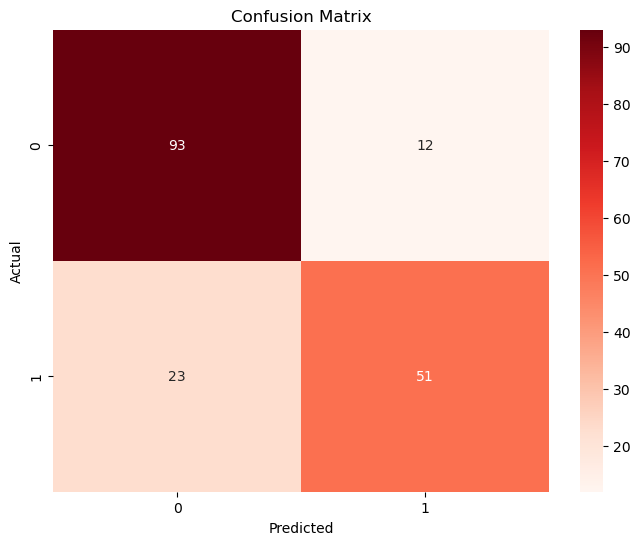

In [48]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred_random)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

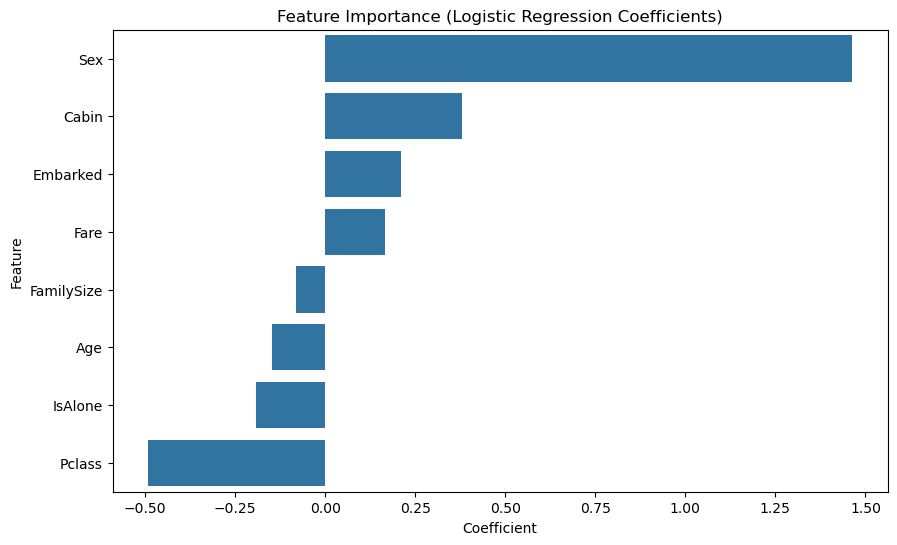

In [50]:
# Feature Importance: coefficients of the logistic regression model
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': random_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coefficients, x='Coefficient', y='Feature')
plt.title("Feature Importance (Logistic Regression Coefficients)") 
plt.show()